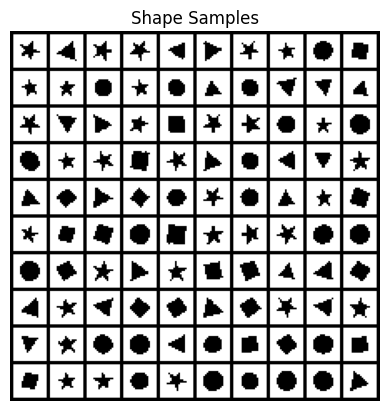

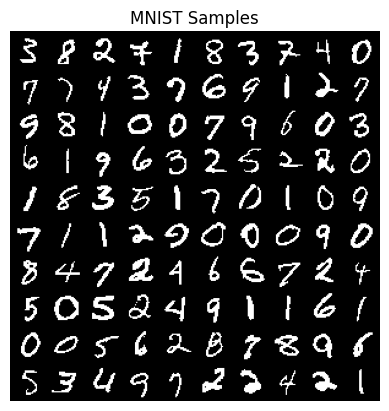

In [30]:
import numpy as np
import sys, os
from os.path import join
repo_path = '/Users/Baiyang/Documents/deepul'
sys.path.append(repo_path)
# add all the subdirectories of the repo to the path
for subdir in os.listdir(repo_path):
    if os.path.isdir(os.path.join(repo_path, subdir)):
        sys.path.append(os.path.join(repo_path, subdir))

from deepul.utils import get_data_dir
from deepul.hw1_helper import (
    # Q1
    visualize_q1_data,
    q1_sample_data_1,
    q1_sample_data_2,
    q1_save_results,
    # Q2
    q2a_save_results,
    q2b_save_results,
    visualize_q2a_data,
    visualize_q2b_data,
    load_pickled_data,
    # Q3
    q3ab_save_results,
    q3c_save_results,
    # Q4
    q4a_save_results,
    q4b_save_results,
    # Q5
    visualize_q5_data,
    q5a_save_results,
    # Q6
    visualize_q6_data,
    q6a_save_results,
)
visualize_q2a_data(1)
visualize_q2a_data(2)

In [31]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from deepul.models.pixelcnn import PixelCNN
from deepul.utils import load_pickled_data, get_data_dir, save_training_plot, show_samples

# Settings
DATASET = 'mnist'  # 'shape' or 'mnist'
BATCH_SIZE = 128
LR = 1e-3
EPOCHS = 20
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load data
data_dir = get_data_dir(1)
loaded = load_pickled_data(os.path.join(data_dir, f'{DATASET}.pkl'))
train_data, test_data = loaded[0], loaded[1]
# Data shape: (N, H, W), values in {0,1}
train_data = train_data.astype(np.float32)
test_data = test_data.astype(np.float32)
# print(train_data.shape)
# print(test_data.shape)    

# Optionally scale to [-1, 1]
# train_data = train_data * 2 - 1
# test_data = test_data * 2 - 1
train_tensor = torch.from_numpy(train_data)
test_tensor = torch.from_numpy(test_data)
train_tensor = train_tensor.permute(0, 3, 1, 2)
test_tensor = test_tensor.permute(0, 3, 1, 2)
print(train_tensor.shape)
print(test_tensor.shape)
train_loader = DataLoader(TensorDataset(train_tensor), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(TensorDataset(test_tensor), batch_size=BATCH_SIZE)

# Model
model = PixelCNN(input_channels=1, n_filters=64, n_classes=1).to(DEVICE)
optimizer = Adam(model.parameters(), lr=LR)

train_losses = []

# Loss: binary cross-entropy with logits
criterion = lambda logits, targets: F.binary_cross_entropy_with_logits(logits, targets, reduction='mean')

def evaluate_test_loss(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    n = 0
    with torch.no_grad():
        for batch, in test_loader:
            batch = batch.to(device)
            logits = model(batch)
            loss = criterion(logits, batch)
            test_loss += loss.item() * batch.size(0)
            n += batch.size(0)
    return test_loss / n

test_losses = [evaluate_test_loss(model, test_loader, criterion, DEVICE)]

for epoch in range(EPOCHS):
    model.train()
    for batch, in train_loader:
        batch = batch[0].to(DEVICE)
        logits = model(batch)
        loss = criterion(logits, batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    # Evaluate test loss
    test_loss = evaluate_test_loss(model, test_loader, criterion, DEVICE)
    test_losses.append(test_loss)
    print(f'Epoch {epoch+1}/{EPOCHS} - Test loss: {test_losses[-1]:.4f}')


torch.Size([60000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])
Epoch 1/20 - Test loss: 0.1236
Epoch 2/20 - Test loss: 0.1040
Epoch 3/20 - Test loss: 0.0981
Epoch 4/20 - Test loss: 0.0957
Epoch 5/20 - Test loss: 0.0968
Epoch 6/20 - Test loss: 0.0955
Epoch 7/20 - Test loss: 0.0957
Epoch 8/20 - Test loss: 0.0946
Epoch 9/20 - Test loss: 0.0973
Epoch 10/20 - Test loss: 0.0975
Epoch 11/20 - Test loss: 0.0919
Epoch 12/20 - Test loss: 0.0914
Epoch 13/20 - Test loss: 0.0919
Epoch 14/20 - Test loss: 0.0899
Epoch 15/20 - Test loss: 0.0914
Epoch 16/20 - Test loss: 0.0914
Epoch 17/20 - Test loss: 0.0912
Epoch 18/20 - Test loss: 0.0919
Epoch 19/20 - Test loss: 0.0898
Epoch 20/20 - Test loss: 0.0887


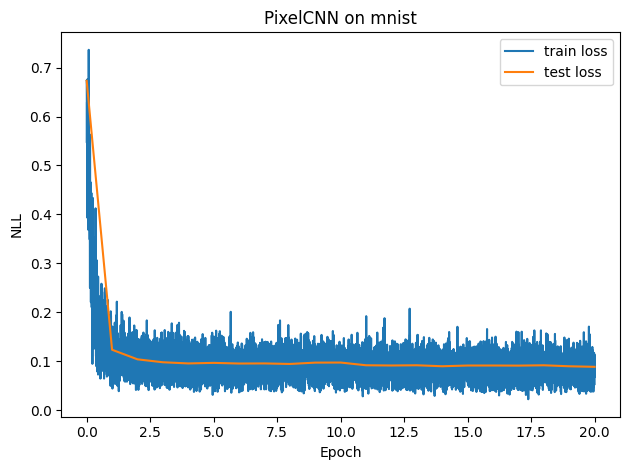

In [32]:
# Save training plot
save_training_plot(np.array(train_losses), np.array(test_losses), f'PixelCNN on {DATASET}', f'homeworks/hw1/results/pixelcnn_{DATASET}_train_plot.png')


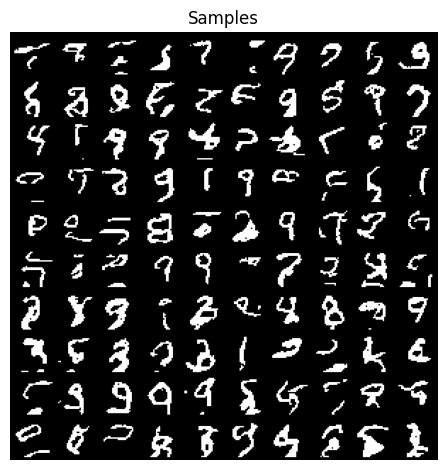

In [33]:
# Generate samples
def sample(model, shape, device):
    H, W, C = shape
    model.eval()
    samples = torch.zeros((100, C, H, W), device=device)
    with torch.no_grad():
        for i in range(shape[0]):
            for j in range(shape[1]):
                logits = model(samples)
                probs = torch.sigmoid(logits[:, :, i, j])
                samples[:, :, i, j] = torch.bernoulli(probs)
    return samples.cpu().numpy().transpose(0, 2, 3, 1) * 255

img_shape = train_data.shape[1:]
samples = sample(model, img_shape, DEVICE)
show_samples(samples, fname=f'homeworks/hw1/results/pixelcnn_{DATASET}_samples.png') 